# Exercise 2: Blackjack

For this exercise, we will learn how to play **Blackjack** by implementing the **Q-learning algorithm**. We will use the environment [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/), which provides a simple interface to interact with the game.


<p align='center'><img src='./images/blackjack.png' alt='drawing' width='500'/></p>


The rules of the Blackjack are the following:

- The game is played with a standard 52-card deck. In the environment each card is draw with replacement (e.g., infinite deck) so card counting isn't possible.
- The player and dealer are each dealt two cards. The player can see one of the dealer's cards.
- The player can choose to **hit** (take another card) or **stick** (keep their current hand).
- The goal is to get as close to 21 as possible without going over.
- If the player's hand exceeds 21, they lose (bust).
- If the player sticks, the dealer reveals their hidden card.
- The dealer must hit until their hand is at least 17.
- If the dealer busts, the player wins.
- If both player and dealer end up with the some total, it's a tie.

Different cards have different values:
- Face cards (Jack, Queen and King): 10
- Aces: can count either 1 or 11 (usable Ace)
- Other cards: same value equal to their number

The rewards are the following:
- Player wins: +1
- Player loses: -1
- Tie: +0

The two possible actions are:
- 0: stick
- 1: hit

In [ ]:
from collections import defaultdict
import os

import imageio
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from tqdm import tqdm

We set the `sab` parameter to `True`, which means that we are using the same rules outlined in the book Reinforcement Learning: An Introduction by Sutton and Barto. If the player gets a natural blackjack (an Ace and a 10-value card) they get a reward of +1. If the dealer gets a natural blackjack, the player gets a reward of -1. If both player and dealer get a natural blackjack, the player gets a reward of +1.

In [2]:
dict_env = {'id': 'Blackjack-v1',
            'sab': True,
            'render_mode': 'rgb_array'}

env = gym.make(**dict_env)

In [3]:
# Set a seed for reproducibility
seed = 4321

# This is the initial state of the environment.
observation, info = env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)

print(f'Initial observation: {observation}')
print(f'Initial info: {info}')

Initial observation: (17, 10, 0)
Initial info: {}


In [4]:
# Set the seed for the action space to ensure reproducibility
env.action_space.seed(seed)

4321

In [ ]:
done = False
total_reward = 0
frames = []

while not done:
    # Save the frame for the video
    frame = env.render()
    frames.append(frame)

    # Sample a random action from the action space
    action = env.action_space.sample()
    
    # Take a step in the environment
    observation, reward, terminated, truncated, info = env.step(action)
    
    # Add the reward to the total reward
    total_reward += reward

    # Check if the episode has ended
    done = terminated or truncated

    print(observation, action)

print('Episode finished. Total reward:', total_reward)

frame = env.render()
frames.append(frame)


env.close()

/Users/sgalella/miniforge3/envs/RL/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(21, 10, 0) 1
(21, 10, 0) 0
Episode finished. Total reward: 0.0


In [ ]:
if not os.path.exists('videos'):
    os.makedirs('videos')

In [ ]:
random_video_path = os.path.join('videos', f'blackjack_random.mp4')
imageio.mimsave(random_video_path, frames, fps=1)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 500) to (608, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [7]:
Video(random_video_path, width=400)

The observation of the environment is a tuple (sum player, sum dealer, usable ace). For example, we get the following prints from the previous game:
1. (21, 10, 0) 1
2. (21, 10, 0) 0

Let's analyze the previous game:

- The agent starts with a hand of 17.
- The agent hits and gets a 4.
- The agent now has a hand of 21, which is a winning hand (Blackjack).
- The dealer shows the second card, which is an ace, summing up to 21 (the Ace can be counted as 1 or 11, whichever is best). This is not rendered in the environment.
- It's a tie, and the agent receives no reward.

Note: Due to randomness, it's possible that this game might be different to you. If so, try to analyze it to make sure you understand the environment.

We can see both hands of the dealer and the player by accessing the atributes of the environment:

In [ ]:
print(f"Dealer's hand: {env.unwrapped.dealer}")
print(f"Player's hand: {env.unwrapped.player}")

Dealer's hand: [10, 1]
Player's hand: [7, 10, 4]


Let's implement the Q-learning algorithm to learn how to play Blackjack. The environment provides a simple interface to interact with the game, and we will use it to train our agent.

We will define a Blackjack agent that learns to play the game using Q-learning. The agent will learn from its experiences and improve its policy over time.

We will need to implement two methods:

- `get_action`: This method will return the action to take based on the current state and the Q-table. We will use an epsilon-greedy policy to balance exploration and exploitation.
- `update`: This method will update the Q-table based on the action taken, the reward received, and the next state. We will use the Q-learning update rule to adjust the Q-values.

Remember the Q-Learning algorithm update:

\begin{equation*}
q_{n+1}(S_t,A_t)
= q_n(S_t,A_t)
+ \alpha\Bigl[\,
  \underbrace{R_{t+1} + \gamma \max_a q_n(S_{t+1},a)}_{\text{target}}
  \;-\;q_n(S_t,A_t)
\Bigr]
\end{equation*}

we will define:



Note that we actually keep track of two step counters:
1. $t$ is the time index within the current episode (so $t=0,1,2,\dots$ resets to 0 at the start of each episode).
2. $n$ is the total update index across all episodes (so $n$ keeps growing even when you start a new episode).

Consequently, after we've taken $t$ steps in episode 1, we have also performed $n=t$ total updates. But once we begin episode 2, $t$ resets to 0 while $i$ continues from where it left off, so in general $i \ge t$ and across episodes $n$ strictly increases.


In [ ]:
class BlackJackAgent:
    def __init__(self,
                 learning_rate=0.01,
                 discount_factor=0.9,
                 epsilon=0.1):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_values = defaultdict(lambda: np.zeros(2))

    def select_action(self, state):
        # We want to select a random action with probability epsilon, otherwise we select the action with the highest Q-value. 
        raise NotImplementedError('You need to implement the epsilon-greedy action selection method.')
        if ... < ...:
            return np.random.choice([0, 1])
        
        # Otherwise, we select the action with the highest Q-value for the current state.
        # If there is a tie, we break it randomly.
        return np.argmax(self.q_values[state])
            
    def update(self, state, action, reward, terminated, next_state):
        # Calculate the target value. Note you need to multiply the next state's maximum Q-value by (not terminated) to ensure that we do not consider future rewards if the episode has ended.
        raise NotImplementedError('You need to implement the Q-value update rule.')
        target = reward + (not terminated) * ... * ...
        self.q_values[state][action] += self.learning_rate * (target - self.q_values[state][action])

<details>
<summary>Double click to see the solution.</summary>

```python
class BlackJackAgent:
    def __init__(self,
                 learning_rate=0.01,
                 discount_factor=0.9,
                 epsilon=0.1):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_values = defaultdict(lambda: np.zeros(2))

    def select_action(self, state):
        # We want to select a random action with probability epsilon, otherwise we select the action with the highest Q-value.
        if np.random.random() < self.epsilon:
            return np.random.choice([0, 1])
        
        # Otherwise, we select the action with the highest Q-value for the current state.
        # If there is a tie, we break it randomly.
        return np.argmax(self.q_values[state])
            
    def update(self, state, action, reward, terminated, next_state):
        # Calculate the target value. Note you need to multiply the next state's maximum Q-value by (not terminated) to ensure that we do not consider future rewards if the episode has ended.
        target = reward + self.discount_factor * (not terminated) * max(self.q_values[next_state])
        self.q_values[state][action] += self.learning_rate * (target - self.q_values[state][action])
```

Let's initialize an agent with the default parameters. Try to change the parameters to see how it changes the results!

In [14]:
learning_rate = 0.01
discount_factor = 0.99
epsilon = 0.1

agent = BlackJackAgent(learning_rate=learning_rate,
                       discount_factor=discount_factor,
                       epsilon=epsilon)

Next, we define the number of episodes. The more episodes you run, the better the agent will perform since we will get better estimates of the q-values. However, it will take longer to train.

In [15]:
num_episodes = 1000000  # Try different values!

In [16]:
rewards = np.zeros(num_episodes)

for i_episode in tqdm(range(num_episodes)):
    state, _ = env.reset(seed=i_episode)  # For reproducibility, we reset the environment with a seed based on the episode number. 
    done = False
    
    while not done:
        # Sample an action using the agent's epsilon-greedy policy
        action = agent.select_action(state)

        # Take a step in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Update the agent's Q-values
        agent.update(state, action, reward, terminated, next_state)
        
        # Update the state for the next iteration
        state = next_state

        # Accumulate the reward for the current episode
        rewards[i_episode] += reward
        
        # Check if the episode has ended
        done = terminated or truncated

env.close()

100%|██████████| 1000000/1000000 [00:50<00:00, 19974.03it/s]


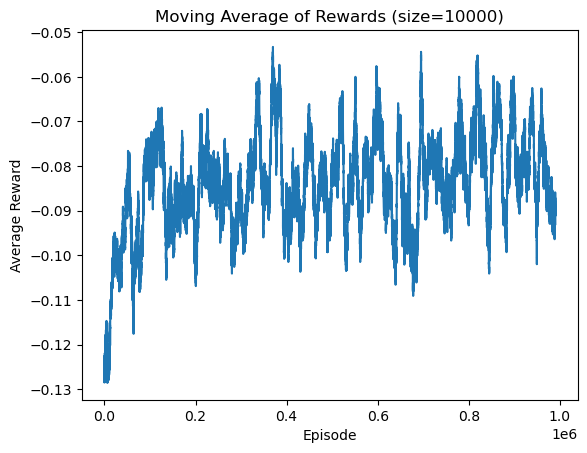

In [17]:
window_size = np.min((num_episodes // 10, 10000))  # Ensure the window size is not too large (might take a long time to compute otherwise)
average_filter = np.ones(window_size) / window_size

plt.plot(np.convolve(rewards, average_filter, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title(f'Moving Average of Rewards (size={window_size})')
plt.show()

Nice, we can see the average reward increasing over time, indicating that the agent is learning to play Blackjack better. Let's plot the state values and the policy to follow at each state.

First of all, let's inspect the q_values learned by the agent. Let's check how many states we have:

We can calculate the total number of possible states if the agent plays enough games.

**Case 1**: Player has no usable ace, and doesn't exceed 21.
- Player sum: 4-21 (18)
- Dealer showing: 1-10 (10)
- Total: 18 x 10 = 180 states

**Case 2**: Player has an usable ace and doesn't exceed 21.
- Player sum: 12-21 (10)
- Dealer showing: 1-10 (10)
- Total: 10 x 10 = 100 states

**Case 3**: Player exceeds 21.
- Player sum: 22-31 (10)
- Dealer showing: 1-10 (10)
- Total: 10 x 10 = 100 states

Sum States = 180 + 100 + 100 = 380

In [18]:
print(len(agent.q_values))

380


Let's see the what's the q-value for the state (21, 10, 0). That is:

- Player sum is 21
- Dealers up card is 10
- No usable ace

Since we got 21, the best action will be to stick, let's see what the agent has learned:

In [19]:
agent.q_values[(21, 10, 0)]

array([ 0.88466709, -0.99987218])

The action 0 (stick) has larger value than action 1 (hit), so the agent has learned that the best action in this state is to stick.

To calculate the state values from the action values, remember from the lecture that:

$$
\pi(s) = \arg\max_a q_\pi(s,a)
\quad\Longrightarrow\quad
\pi(a\mid s) =
\begin{cases}
1 & \text{if }a = \arg\max_a q_\pi(s,a),\\
0 & \text{otherwise.}
\end{cases}
$$

and that by the relationship of the state-values and action values:

$$
v_\pi(s) = \sum_{a \in A} \pi (a|s) q_\pi(s, a)
$$

then:

$$
v_\pi(s) = \max_a q_\pi(s, a)
$$

Let's plot the state-values for the combination of player sums and dealer up-cards.

In [20]:
# We are going to plot the state-çvalues for sums up to 21 (no busts).
player_sums = range(12, 22)
dealer_upcards = range(1, 11)

num_player_sums = len(player_sums)
num_dealer_upcards = len(dealer_upcards)

#### Exercise 2.2: Calculate the state value for usable and non-usable Aces

In [ ]:
# We fill the matrices with the state value (maximum Q-value) for each state.
V_usable = np.zeros((num_player_sums, num_dealer_upcards))
V_non_usable = np.zeros((num_player_sums, num_dealer_upcards))

for i_player, player_sum in enumerate(player_sums):
    for i_dealer, dealer_upcard in enumerate(dealer_upcards):
        # Calculate the state value for usable Ace and non-usable Ace by taking the maximum Q-value for the respective states.
        raise NotImplementedError('You need to implement the state value calculation for usable and non-usable Aces.')
        V_usable[i_player, i_dealer] = ...
        V_non_usable[i_player, i_dealer] = ...

<details>
<summary>Double click to see the solution.</summary>

```python
# We fill the matrices with the state value (maximum Q-value) for each state.
V_usable = np.zeros((num_player_sums, num_dealer_upcards))
V_non_usable = np.zeros((num_player_sums, num_dealer_upcards))

for i_player, player_sum in enumerate(player_sums):
    for i_dealer, dealer_upcard in enumerate(dealer_upcards):
        V_usable[i_player, i_dealer] = max(agent.q_values[(player_sum, dealer_upcard, 1)])
        V_non_usable[i_player, i_dealer] = max(agent.q_values[(player_sum, dealer_upcard, 0)])
````

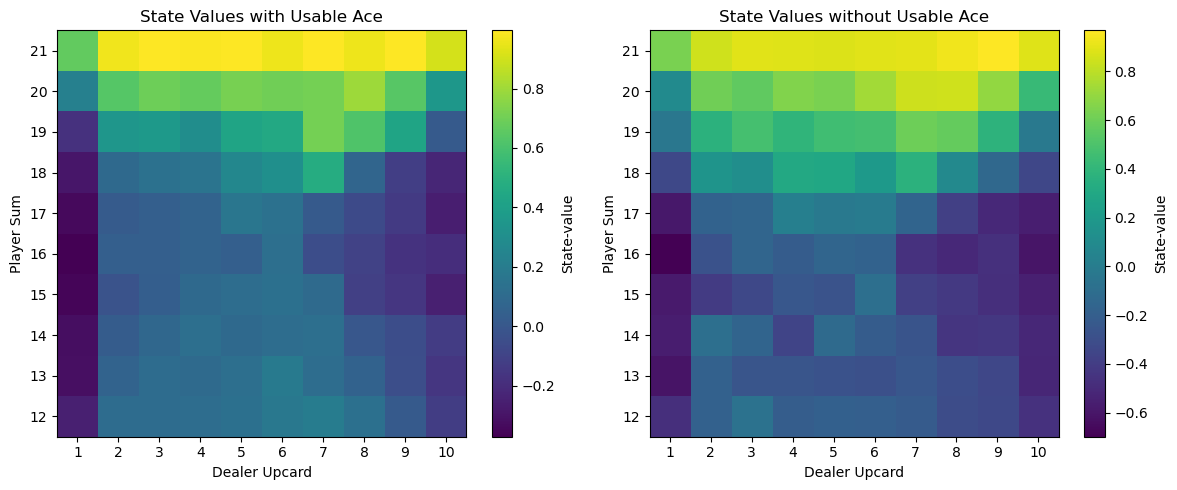

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

im_usable = ax[0].imshow(V_usable, origin='lower', cmap='viridis', aspect='auto')
ax[0].set_title('State Values with Usable Ace')
ax[0].set_xlabel('Dealer Upcard')
ax[0].set_ylabel('Player Sum')
ax[0].set_xticks(range(num_dealer_upcards))
ax[0].set_xticklabels(dealer_upcards)
ax[0].set_yticks(range(num_player_sums))
ax[0].set_yticklabels(player_sums)
fig.colorbar(im_usable, ax=ax[0], label='State-value')

im_non_usable = ax[1].imshow(V_non_usable, origin='lower', cmap='viridis', aspect='auto')
ax[1].set_title('State Values without Usable Ace')
ax[1].set_xlabel('Dealer Upcard')
ax[1].set_ylabel('Player Sum')
ax[1].set_xticks(range(num_dealer_upcards))
ax[1].set_xticklabels(dealer_upcards)
ax[1].set_yticks(range(num_player_sums))
ax[1].set_yticklabels(player_sums)
fig.colorbar(im_non_usable, ax=ax[1], label='State-value')
plt.tight_layout()

plt.show()

**Question**: What states have lower values? What states have higher values? Why?

<details>
<summary>Double click to see the solution.</summary>

States with player sums close to 21 have higher state-values because they’re more likely to yield a win or draw. Conversely, low-sum states have lower values, since you can only win them in the rare event that the dealer busts.

Let's plot now the policy for each state:

#### Exercise 2.3: Calculate the policy for usable and non-usable Aces

In [ ]:
# We fill the matrices with the policy (best action) for each state.
pi_usable = np.zeros((num_player_sums, num_dealer_upcards))
pi_non_usable = np.zeros((num_player_sums, num_dealer_upcards))

for i_player, player_sum in enumerate(player_sums):
    for i_dealer, dealer_upcard in enumerate(dealer_upcards):
        # Calculate the policy for usable Ace and non-usable Ace by taking the argmax Q-value for the respective states.
        raise NotImplementedError('You need to implement the policy calculation for usable and non-usable Aces.')
        pi_usable[i_player, i_dealer] = ...
        pi_non_usable[i_player, i_dealer] = ...

<details>
<summary>Double click to see the solution.</summary>

```python
# We fill the matrices with the policy (best action) for each state.
pi_usable = np.zeros((num_player_sums, num_dealer_upcards))
pi_non_usable = np.zeros((num_player_sums, num_dealer_upcards))

for i_player, player_sum in enumerate(player_sums):
    for i_dealer, dealer_upcard in enumerate(dealer_upcards):
        pi_usable[i_player, i_dealer] = np.argmax(agent.q_values[(player_sum, dealer_upcard, 1)])
        pi_non_usable[i_player, i_dealer] = np.argmax(agent.q_values[(player_sum, dealer_upcard, 0)])
```

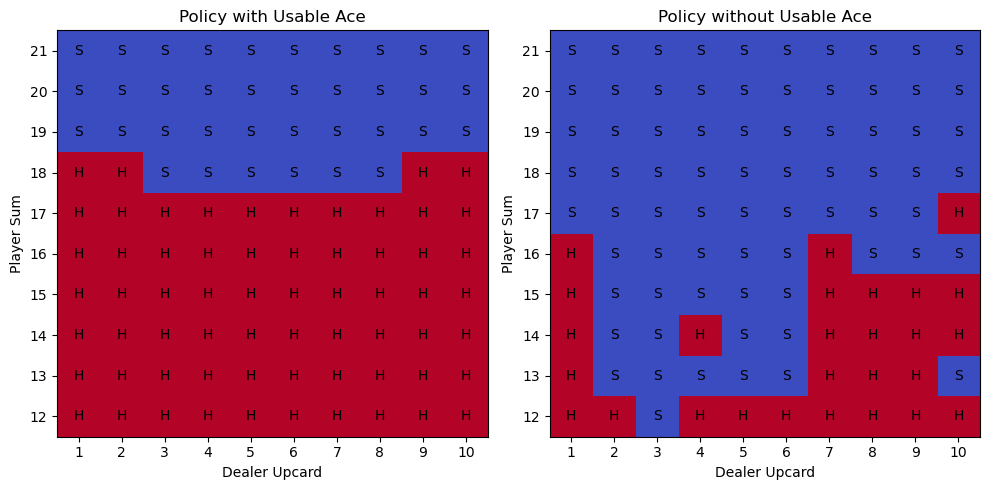

: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im_usable = ax[0].imshow(pi_usable, origin='lower', cmap='coolwarm', aspect='auto')
ax[0].set_title('Policy with Usable Ace')
ax[0].set_xlabel('Dealer Upcard')
ax[0].set_ylabel('Player Sum')
ax[0].set_xticks(range(num_dealer_upcards))
ax[0].set_xticklabels(dealer_upcards)
ax[0].set_yticks(range(num_player_sums))
ax[0].set_yticklabels(player_sums)

for i in range(pi_usable.shape[0]):
    for j in range(pi_usable.shape[1]):
        action = 'H' if pi_usable[i,j] == 1 else 'S'
        ax[0].text(j, i, action, ha='center', va='center', color='black')

im_non_usable = ax[1].imshow(pi_non_usable, origin='lower', cmap='coolwarm', aspect='auto')
ax[1].set_title('Policy without Usable Ace')
ax[1].set_xlabel('Dealer Upcard')
ax[1].set_ylabel('Player Sum')
ax[1].set_xticks(range(num_dealer_upcards))
ax[1].set_xticklabels(dealer_upcards)
ax[1].set_yticks(range(num_player_sums))
ax[1].set_yticklabels(player_sums)

for i in range(pi_non_usable.shape[0]):
    for j in range(pi_non_usable.shape[1]):
        action = 'H' if pi_non_usable[i,j] == 1 else 'S'
        ax[1].text(j, i, action, ha='center', va='center', color='black')

plt.tight_layout()

plt.show()

### Summary

- In this notebook, we implemented a simple Blackjack agent using **Q-learning**. In Q-learning is model-free algorithm, meaning the agent learns the optimal action-value function from sampled experience, without needing a model of the environment.

- We have implemented $\epsilon$-greedy strategy to address the **exploitation-exploration** dilemma. From time to time, the agent will behave randomly to explore new states, which will help to find a better policy.

- Finally, we recovered the state values and policy from the action values learned by the agent.